In [1]:
!pip install sc-toolbox pertpy

  Using cached sc_toolbox-0.12.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached pertpy-0.9.4-py3-none-any.whl.metadata (6.9 kB)
  Using cached pypi_latest-0.1.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached questionary-2.0.1-py3-none-any.whl.metadata (5.4 kB)
  Using cached decoupler-1.8.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached lamin_utils-0.13.4-py2.py3-none-any.whl.metadata (980 bytes)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached PubChemPy-1.0.4-py3-none-any.whl
  Using cached scikit_misc-0.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached scvi_tools-1.1.6.post2-py3-none-any.whl.metadata (18 kB)
  Using cached prompt_toolkit-3.0.36-py3-none-any.whl.metadata (7.0 kB)
  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached mudata-0.3.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.meta

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import itertools 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
from tqdm import tqdm

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
%%R
library(edgeR)
library(MAST)

Loading required package: limma
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2

In [4]:
adata = pertpy.data.srivatsan_2020_sciplex2()

# way too big
# adata = pertpy.data.srivatsan_2020_sciplex3()

In [5]:
adata.layers["raw_counts"]   = adata.X.copy()
# sc.pp.log1p(adata)
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

**Design Considerations**
1. 1 Cell Line (A549)
2. 4 Compounds
3. 7 Different Doses In Triplicates
4. 84 Drug-Dose-Replciate Combinations

In [6]:
doses                   = adata.obs['dose_value'].unique()
perturbations           = adata.obs['perturbation'].unique()  # Drug Pertubation or Control
combinations            = itertools.product(doses, perturbations)

adata.obs['Condition']  = [str(adata.obs['dose_value'][index]) + ' ' +  str(adata.obs['perturbation'][index]) 
                        if str(adata.obs['dose_value'][index]) != 'nan' else str(adata.obs['perturbation'][index])
                        for index in adata.obs.index]
                        


In [7]:
adata_hvg     = adata.copy()

# sc.pp.highly_variable_genes(adata_hvg)

aggregate_and_filter is a function that creates an AnnData object with one pseudo-replicate for each donor for a specified subpopulation from the original single-cell AnnData object. Here, we also filter out donors that have fewer than 30 cells for the specified population.


In [8]:
def aggregate_and_filter(
    adata,
    condition_key            = 'Condition',
    cell_identity_key        = 'celltype',
    obs_to_keep              = [],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_condition = 1,
    min_cells_per_condition  = 30, 
):

    adata_df          = adata.to_df()
   
    unique_conditions = adata.obs.Condition.unique()

    # Drop Conditions with Insufficient Data

    
    size_by_condition  = adata.obs.groupby([condition_key]).size()
    condition_to_drop = [
        condition
        for condition in size_by_condition.index
        if size_by_condition[condition] <= min_cells_per_condition
    ]

    if len(condition_to_drop) > 0:
        print("Dropping the following samples:")
        print(condition_to_drop)
    

    pseudo_bulk      = {}
    condition_groups = []
    split_lengths    = []
    replicates       = []
    for condition in tqdm(unique_conditions, total = len(unique_conditions)):
        subset_condition  = adata.obs[adata.obs[condition_key] == condition]
        
        # Shuffle the indexes
        if replicates_per_condition > 1:
            shuffled_indexes  = np.random.permutation(subset_condition.index)
            splits            = np.array_split(shuffled_indexes, replicates_per_condition)
            
            # Assign Categorical Variable With Pseudo Replicates
            adata.obs['Psuedo Replicates'] = np.nan
            for rep, split in enumerate(splits, start = 1):
                adata.obs.loc[split, 'Psuedo Replicates'] = rep
                
                
                pseudo_bulk[condition + f' {rep}']      = adata_df.loc[split].sum()

                split_length                  = len(split)
                split_lengths.append(split_length)
                condition_groups.append(condition)
                replicates.append(rep)

        else:
            pseudo_bulk[condition]       = adata_df.loc[subset_condition.index].sum()
            condition_groups.append(condition)

    
    conditions          = list(pseudo_bulk.keys())
    pseudo_bulk         = pd.concat([pseudo_bulk[condition] for condition in pseudo_bulk.keys()], axis = 1)
    pseudo_bulk.columns = conditions

    pseudo_bulk        = pseudo_bulk.transpose()
    return pseudo_bulk, condition_groups, split_lengths, replicates


pseudo_bulk, condition_groups, split_lengths, replicates = aggregate_and_filter(adata_hvg, replicates_per_condition = 3)


100%|██████████| 33/33 [00:03<00:00,  9.12it/s]


**Vehicle Controls are Present**
1. 0 Dose Conditions with Drugs have the Drug Delivery Mechanism/Solvent but not the drug itself
2. Vehicle Controls will allow us to analyze any effects of the drug delivery mechanisms
3. Control condition will in theory be able to distingiush drug and delivery affects

In [9]:
adata_pb                             = sc.AnnData(pseudo_bulk)

adata_pb.layers['counts']            = adata_pb.X.copy()
adata_pb.obs['condition']            = condition_groups
adata_pb.obs['lib_size']             = pseudo_bulk.sum(axis = 1)
adata_pb.obs['cells_per_replicate']  = split_lengths
adata_pb.obs['replicate']            = replicates

**Considerations for Normalizing**
1. is ther a bioligcal reason the count depth on different treatments varies so much?

In [10]:
target_sum      = 1300000 # Median and Mean are 1.5 and 1.3 million respectively
sc.pp.normalize_total(adata_pb, target_sum=target_sum)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

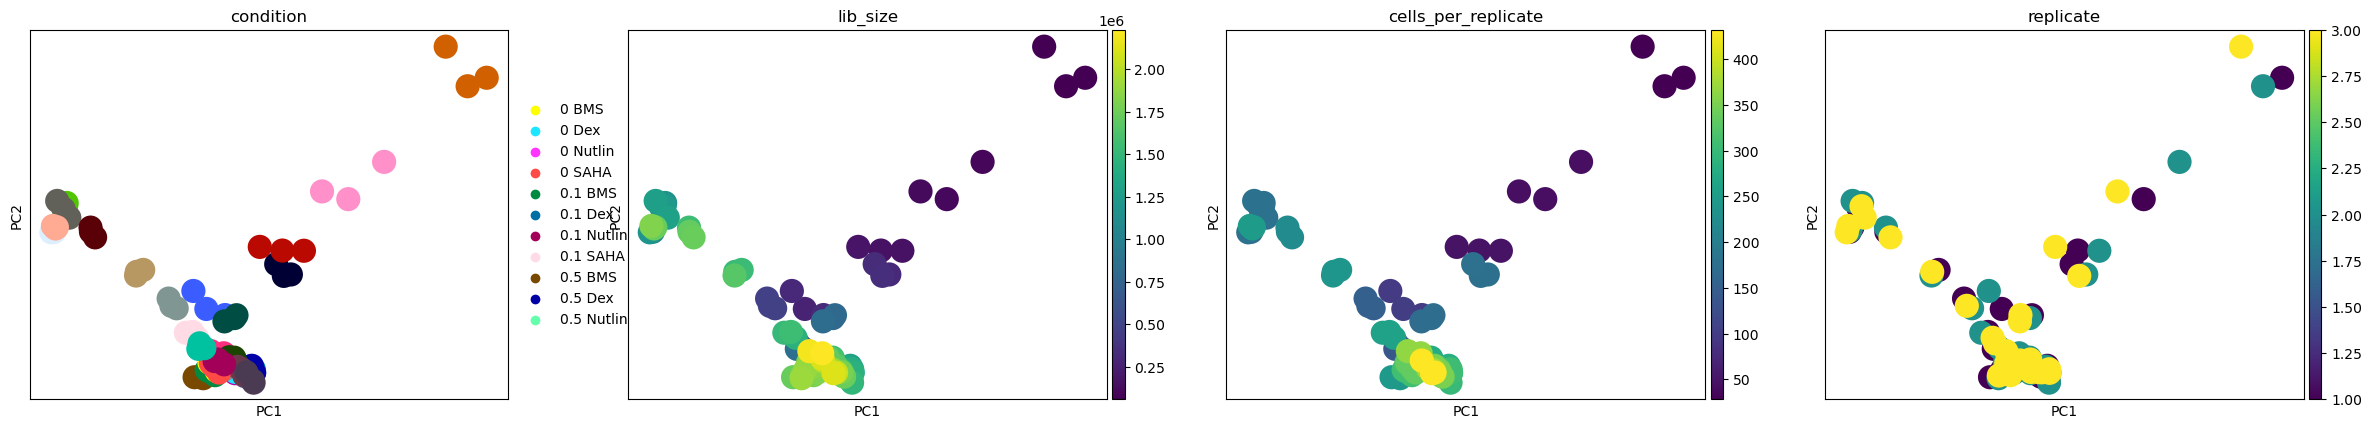

In [11]:
sc.pl.pca(adata_pb, color = adata_pb.obs)

**From Single Cell Textbook**
1. fit_model takes a SingleCellExperiment object as input, creates the design matrix and outputs the fitted GLM. We also output the edgeR object of class DGEList to do some exploratory data analysis (EDA).
2. GLM: Geneleral Linearized Model: https://online.stat.psu.edu/stat504/lesson/6/6.1

**Will have to change this**

In [12]:
%%R
fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$condition)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y         <- calcNormFactors(y)
    # create a vector that is a concatenation of condition and cell type that we will later use with contrasts
    group     <- paste0(colData(adata_)$condition)
    # replicate <- rownames(colData(adata_))

    # print(colData(adata_))
    replicate <- colData(adata_)$replicate

    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + group + replicate)

    # estimate dispersion
    y <- estimateDisp(y, design = design)
    
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

**edgeR Takes raw counts as inputs**
1. No spaces can be present in fit_model for edgeR makeContrasts

In [13]:
adata_r     = adata_pb.copy()
adata_r.X   = adata_r.layers['counts']
adata_r.obs['condition'] = [condition.replace(' ', '_') for condition in adata_r.obs['condition']]

**Error raised when raw_counts passed vs log_counts as was done before with adata_pb**

In [41]:
%%time
%%R -i adata_r
outs <-fit_model(adata_r)

[1] "Dimensions before subsetting:"
[1] 35916    99
[1] ""
[1] "Dimensions after subsetting:"
[1] 16462    99
[1] ""
CPU times: user 3min 42s, sys: 4.62 s, total: 3min 46s
Wall time: 3min 53s


**Extract Model Fits**

In [42]:
%%R
fit <- outs$fit
y <- outs$y

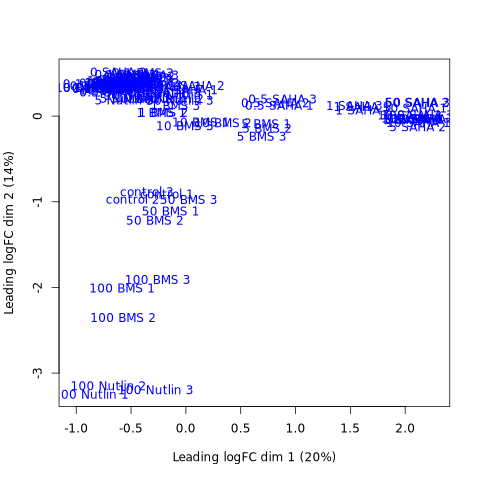

In [43]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

**A lot of Biological Coefficient of Variation**
1. A strip of genes below the red line
2. This makes sense we are doing drug treatments

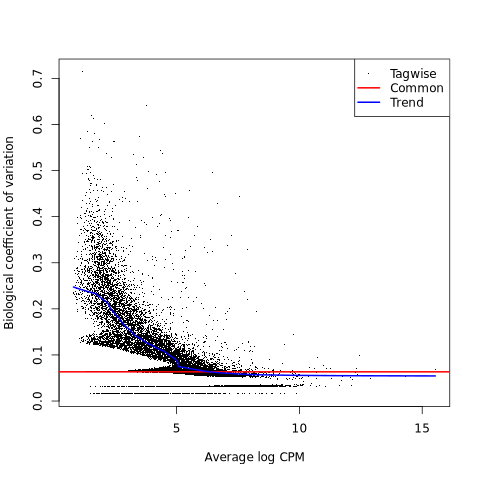

In [44]:
%%R
plotBCV(y)

**Possible Groups to makeContracts for in function below**

In [45]:
%%R
colnames(y$design)

 [1] "group0_BMS"      "group0_Dex"      "group0_Nutlin"   "group0_SAHA"    
 [5] "group0.1_BMS"    "group0.1_Dex"    "group0.1_Nutlin" "group0.1_SAHA"  
 [9] "group0.5_BMS"    "group0.5_Dex"    "group0.5_Nutlin" "group0.5_SAHA"  
[13] "group1_BMS"      "group1_Dex"      "group1_Nutlin"   "group1_SAHA"    
[17] "group10_BMS"     "group10_Dex"     "group10_Nutlin"  "group10_SAHA"   
[21] "group100_BMS"    "group100_Dex"    "group100_Nutlin" "group100_SAHA"  
[25] "group5_BMS"      "group5_Dex"      "group5_Nutlin"   "group5_SAHA"    
[29] "group50_BMS"     "group50_Dex"     "group50_Nutlin"  "group50_SAHA"   
[33] "groupcontrol"    "replicate"      


In [48]:
%%R -o tt
myContrast <- makeContrasts('groupcontrol-group100_SAHA', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [53]:
%%R 
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)

**Allows you to see the callable attributes of the qlf object**

In [60]:
%%R
attributes(qlf)

$names
 [1] "coefficients"          "fitted.values"         "deviance"             
 [4] "iter"                  "failed"                "method"               
 [7] "unshrunk.coefficients" "df.residual"           "design"               
[10] "offset"                "dispersion"            "prior.count"          
[13] "AveLogCPM"             "df.residual.zeros"     "df.prior"             
[16] "var.post"              "var.prior"             "samples"              
[19] "table"                 "comparison"            "df.test"              
[22] "df.total"             

$class
[1] "DGELRT"
attr(,"package")
[1] "edgeR"



**R Querying Breakdown**
1. which(tt$FDR<0.001) pulls the indeses from the tt object and attribuet FDR where FDR < 0.001
2. rownames(tt) prefixed with query 1 gives the names of the genes that allow this condition to be truea

In [57]:
%%R
rownames(tt)[which(tt$FDR<0.001)]

   [1] "PDE4D"        "ALDOA"        "P4HB"         "UBC"         
   [5] "PSAP"         "PLEC"         "UBB"          "GPRC5A"      
   [9] "ASPH"         "CD81"         "BSG"          "CLU"         
  [13] "PTPRM"        "FLNA"         "ALDH1A1"      "EHBP1"       
  [17] "MTUS1"        "THSD7A"       "NFIA"         "STC1"        
  [21] "AKAP12"       "EFNA5"        "CALR"         "MIR31HG"     
  [25] "TFRC"         "THSD4"        "PVT1"         "RPS5"        
  [29] "QSOX1"        "MGST1"        "APLP2"        "KYNU"        
  [33] "NOP56"        "CKB"          "PKM"          "SLC9A3R1"    
  [37] "GPC6"         "ZBTB20"       "NRIP1"        "LPP"         
  [41] "PARD3"        "MAML3"        "EXT1"         "NRP1"        
  [45] "TCF12"        "RPL18"        "SQSTM1"       "TGFB1"       
  [49] "NR3C1"        "SLC22A3"      "SLC1A5"       "SIRT2"       
  [53] "AKR1C2"       "PAPPA"        "PNPLA2"       "DOCK5"       
  [57] "DHCR7"        "MIR3681HG"    "ATP1A3"       "MAP7"    

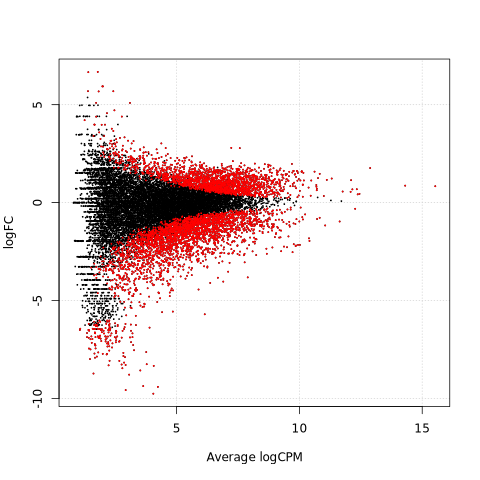

In [54]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])